In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# datos

**usarios con Control** = 0

**usarios con Depresión** = 1


**usarios con Ansiedad** = 2

**PREPARACIÓN DE DATOS**

*Cargar y limpiar*

In [ ]:
!pip install pyspellchecker
!pip install spacy
!python -m spacy download es_core_news_sm

# limpiar texto y Crear Tokens

In [ ]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter='\t')  # Indicamos el delimitador como '\t' para TSV
        return data
    except Exception as e:
        print("Error:", e)
        return None

#Creamos un función de limpieza del texto y  los guarde en tokens indivicuales o lista de palabras
def clean_doc(text):
    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)

    # Eliminar URLs o enlaces
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

    # Eliminar nombres de usuarios de Twitter
    text = re.sub(r'@\w+', '', text)

    # Eliminar Nombres propios
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

    # Eliminar todos los caracteres especiales
    text = re.sub(r'[^\w\s]+', '', text)

    # Eliminar prefijos y números
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

    # Eliminar palabras específicas
    specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                      'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                      'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                      'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                      'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                      'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                      'it','we','they','the','and','that','these','those','tweet','followed','follower']
    text = ' '.join([word for word in text.split() if word not in specific_words])

    # Eliminar emojis
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                 '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                 ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')

    # Convertir el texto a minúsculas
    text = text.lower()

    return text


In [ ]:
def process_docs(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            text = clean_doc(text)
            texts.append(text.split())  # Dividir el texto en palabras
    return texts

In [ ]:
# Cargar y preprocesar documentos
Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/')
Ans = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/')
Dep = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de depresión 2/')

In [ ]:
# Concatenar listas de textos
all_texts = Dep + Cont + Ans

# Entrenar el modelo Word2Vec
modelW = Word2Vec(sentences=all_texts, vector_size=300, window=5, min_count=1, sg=0)


In [ ]:
def document_vector(tokens, modelW):
    # Filtrar palabras que no están en el modelo
    tokens = [token for token in tokens if token in modelW.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(modelW.vector_size)
    return np.mean([modelW.wv[token] for token in tokens], axis=0)


In [ ]:
# Vectorizar los documentos usando la función document_vector
X = np.array([document_vector(doc, modelW) for doc in all_texts])

In [ ]:
X.shape

(270, 300)

In [ ]:
print(modelW)
print(len(modelW.wv))
# Observamos el vocabulario creado
words = modelW.wv.index_to_key
print(words)

Word2Vec<vocab=107259, vector_size=300, alpha=0.025>
107259
['que', 'iphone', 'control', 'depression', 'anxiety', 'httpurl', 'con', 'los', 'por', 'para', 'una', 'las', 'pero', 'como', 'del', 'más', 'todo', 'porque', 'cuando', 'ser', 'eso', 'bien', 'son', 'esta', 'estoy', 'está', 'qué', 'hay', 'tengo', 'así', 'quiero', 'vida', 'nada', 'muy', 'día', 'solo', 'ver', 'este', 'sin', 'todos', 'voy', 'tiene', 'mis', 'hace', 'gente', 'hacer', 'mejor', 'tan', 'siempre', 'nos', 'mucho', 'vez', 'soy', 'ahora', 'algo', 'les', 'mas', 'sus', 'años', 'amo', 'hasta', 'hoy', 'cosas', 'mal', 'fue', 'ese', 'esto', 'esa', 'era', 'también', 'puede', 'puedo', 'tener', 'sea', 'verdad', 'estar', 'nunca', 'menos', 'gracias', 'alguien', 'días', 'dos', 'mismo', 'tanto', 'casa', 'tiempo', 'cuenta', 'amor', 'cada', 'están', 'otra', 'desde', 'uno', 'personas', 'veces', 'decir', 'ganas', 'siento', 'mundo', 'nadie', 'bueno', 'tienen', 'mierda', 'después', 'igual', 'donde', 'gusta', 'creo', 'otro', 'año', 'jajaja', 'di

In [ ]:
# Obtener la representación vectorial de una palabra específica
vector = modelW.wv['depresión']
vector

array([-4.05146256e-02,  4.54565734e-02, -2.66696155e-01,  6.50230706e-01,
        1.14693558e-02, -7.23786473e-01,  1.50594249e-01,  7.11819172e-01,
       -2.53726095e-01,  1.47101864e-01, -2.82978177e-01, -6.26630604e-01,
       -3.43162268e-01,  1.50464967e-01, -2.95823723e-01, -7.15794861e-02,
        1.21043161e-01, -7.86769390e-02,  9.56529826e-02, -3.71319443e-01,
        1.80439234e-01, -3.81687462e-01,  1.10078670e-01, -1.60717424e-02,
        6.08037591e-01, -5.99980652e-01, -2.62851149e-01,  9.53516513e-02,
       -7.20805526e-01, -8.11326087e-01,  2.00793713e-01,  5.36421761e-02,
        5.35389841e-01,  1.21422388e-01, -3.93648475e-01,  1.75496340e-01,
        3.52180600e-01,  7.07480982e-02, -1.37263298e-01,  1.57194600e-01,
       -1.45048380e-01, -3.70903388e-02, -1.73577935e-01, -3.36669646e-02,
        3.34558815e-01,  3.37868452e-01, -4.89275493e-02,  7.12928653e-01,
        3.70201707e-01,  3.36129755e-01, -3.81187648e-02,  2.15347603e-01,
        8.95160958e-02,  

In [ ]:
# Crear etiquetas para los datos
Y = np.array([1] * len(Dep) + [0] * len(Cont) + [2] * len(Ans))



# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Verificar las dimensiones después de la división
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_val:", y_val.shape)


Dimensiones de X_train: (216, 300)
Dimensiones de y_train: (216,)
Dimensiones de X_val: (54, 300)
Dimensiones de y_val: (54,)


In [ ]:
y_train

array([0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0, 1,
       1, 0, 2, 1, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0,
       1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0,
       0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0,
       0, 2, 0, 1, 0, 0, 2, 2, 1, 2, 1, 1, 2, 0, 1, 0, 0, 1, 2, 2, 1, 1,
       2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1,
       2, 1, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 0, 2,
       2, 2, 1, 1, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 0, 0, 0, 1, 2, 0, 2, 1, 2, 1, 0, 0])

**Modelo análisis de texto**

#Red neuronal

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características en X_train
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=30, batch_size=20, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

Epoch 1/30
11/11 [==============================] - 2s 45ms/step - loss: 1.0672 - categorical_accuracy: 0.4444 - val_loss: 1.1301 - val_categorical_accuracy: 0.3148
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 1.0257 - categorical_accuracy: 0.4676 - val_loss: 0.9349 - val_categorical_accuracy: 0.6111
Epoch 3/30
11/11 [==============================] - 0s 13ms/step - loss: 0.9295 - categorical_accuracy: 0.5509 - val_loss: 0.8449 - val_categorical_accuracy: 0.5556
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 0.8730 - categorical_accuracy: 0.5509 - val_loss: 0.7544 - val_categorical_accuracy: 0.6481
Epoch 5/30
11/11 [==============================] - 0s 15ms/step - loss: 0.8311 - categorical_accuracy: 0.5694 - val_loss: 0.7558 - val_categorical_accuracy: 0.4815
Epoch 6/30
11/11 [==============================] - 0s 13ms/step - loss: 0.8179 - categorical_accuracy: 0.5880 - val_loss: 0.7764 - val_categorical_accuracy: 0.4815
Epoch 7/30

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 93.0%
Precisión (entrenamiento): 93.0%
Recall (entrenamiento): 93.0%
F1-score (entrenamiento): 93.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 87.0%
Precisión en el conjunto de validación: 88.0%
Recall en el conjunto de validación: 87.0%
F1-score en el conjunto de validación: 87.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[66  3  4]
 [ 0 68  5]
 [ 0  3 67]]


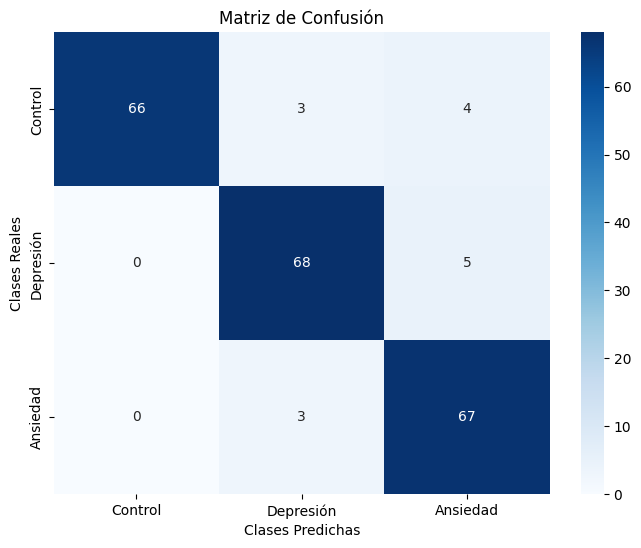

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo Bosque Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=300,  # Número de árboles
    max_depth=100,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)

# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

Precisión (Validación): 0.89
Precisión (Validación): 0.90
Exhaustividad (Validación): 0.89
Puntuación F1 (Validación): 0.89

Métricas en el conjunto de entrenamiento:
Precisión: 1.00
Exhaustividad: 1.00
Puntuación F1: 1.00


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 88.89%
Precisión  validación: 90.04%
Recall  validación: 88.89%
Puntuación F1 validación: 88.92%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[16  0  1]
 [ 0 13  4]
 [ 0  1 19]] 



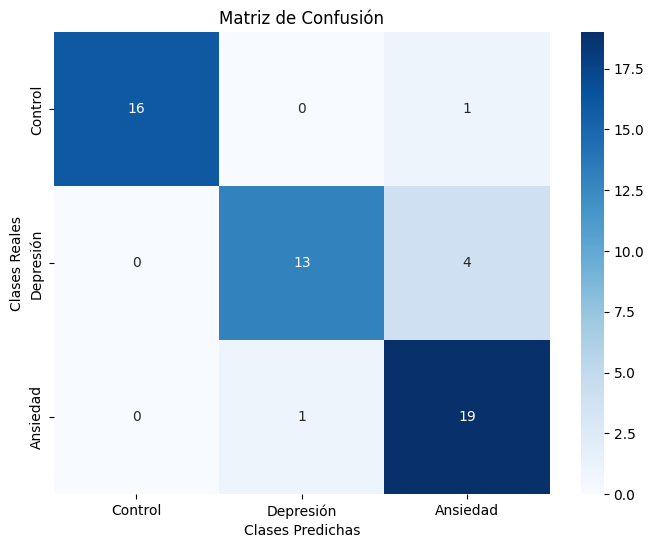

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC


# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='poly', degree=4, C=100,max_iter=500000,  probability=False)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))



Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 99.54%
Precisión (entrenamiento): 99.54%
Recall (entrenamiento): 99.54%
F1-score (entrenamiento): 99.54%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 94.44%
Precisión en el conjunto de validación: 94.75%
Recall en el conjunto de validación: 94.44%
F1-score en el conjunto de validación: 94.45%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[17  0  0]
 [ 1 16  0]
 [ 0  2 18]] 



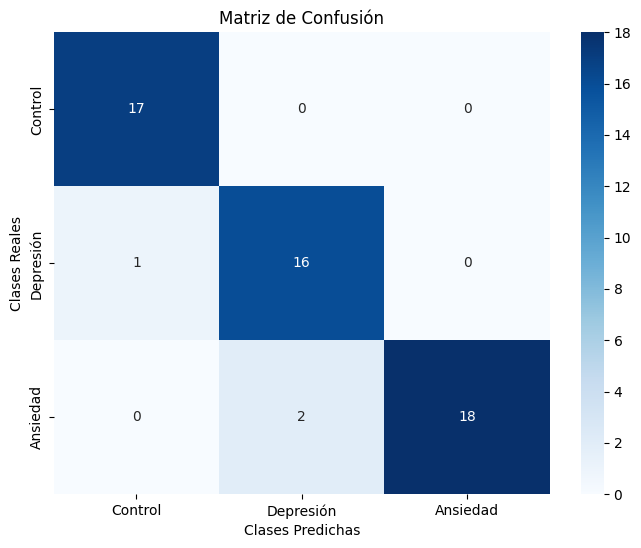

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()